<a href="https://colab.research.google.com/github/St-Jester/mmds_final_project/blob/main/FinalProjectDocker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

This is a final project for Mining Massive Datasets course for master program UCU. <br>
The project was done by Kateryna Zabava and Bohdan Matviiv.

Here we use sseclient to read stream from wiki. we first read 20% of dataset. the approach is described is the cell.

Next we train the model RandomForestClassifier using features "comment", "title", "type". 

"comment", "title" were prepared using Tf-Idf approach.

Model results reported in сorresponding cells. 


After this we used data to test our model. we used 2 bloom filters: one for true users and one for bots. This is done to improve the accracy of the filter.

Our filters are set to show error rate of 10%

the report with results is presented in the end of the work.

In [ ]:
!pip install sseclient

In [ ]:
!pip install bloom-filter

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:
sc.version 

'3.0.1'

## Get 20% of data to train

In [ ]:
##new version with sampling
#gets 20% of data using hash. hash gives us string of numbers and we select an entry if last 2 digits are last_digit==4 or last_digit==9. 
# this means that we have probability of this event of 20% and it reflects on the dataset as 20% of stream entries
import json
from sseclient import SSEClient as EventSource
# use sinse to speed up the process of working
url = 'https://stream.wikimedia.org/v2/stream/recentchange?since=2020-09-22T19:05:11.866740'
wiki = 'enwiki' #Client side filter
counter = 0 
sample_counter = 0
# maxEvents = 1000 # print n events and stop
max_sampled_events = 10000 # required ammount of sample 

users = {}
changes = []
changes_sample = []

start = time.time()
for event in EventSource(url):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
        except ValueError:
            continue
        if change['wiki'] == wiki:
            users[change['user']] = change['wiki']
            change.pop('meta', None)
            
            
            change_json = json.dumps(change, indent = 4)   
#             changes.append(change_json)

            last_digit = hash(change_json) % 10 
            if last_digit==4 or last_digit==9:
                changes_sample.append(change_json)
                if sample_counter%(max_sampled_events/10) == 0:
                    sub_end = time.time()
                    print(f"{sub_end - start}s : done {sample_counter}")
                sample_counter +=1
                
              
            counter += 1 
            if sample_counter == max_sampled_events:
                print('finished')
                break
                
                
end = time.time()
print("Time elapsed %.2f seconds" % (end - start) )

0.8165695667266846s : done 0
14.301051616668701s : done 1000
27.792379140853882s : done 2000
43.64147639274597s : done 3000
53.19105935096741s : done 4000
63.38219237327576s : done 5000
75.39816784858704s : done 6000
88.42375063896179s : done 7000
96.55106949806213s : done 8000
105.18387794494629s : done 9000
finished
Time elapsed 115.34 seconds


In [ ]:
df = spark.read.json(sc.parallelize(changes_sample))
df.show(10, truncate=False)

+-----------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------+----------+------------------+------+----------+--------+-----+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------------------+----------------+------------------+------------------------+----------+------------------------------------------------------------------------+----------+------------+------+
|$schema                      |bot  |comment                                                                     

In [ ]:
df.count()

10000

In [ ]:
# cast types -- needed for the model to correclty detect labels
from pyspark.sql.types import DoubleType
df = df.withColumn("bot_int", df.bot.cast('integer'))


In [ ]:
# bloom filter with error_rate=0.1 will be used later
# from bloom_filter import BloomFilter
# bloom = BloomFilter(error_rate=0.1)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler
import time
# Load and parse the data file, converting it to a DataFrame.
data = df


# todo: perforn tf-idf
tokenizer = Tokenizer(inputCol="comment", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
idf = IDF(inputCol="rawFeatures", outputCol="features")

tokenizer_title = Tokenizer(inputCol="title", outputCol="words_title")
hashingTF_title = HashingTF(inputCol="words_title", outputCol="rawFeatures_title", numFeatures=20)
idf_title = IDF(inputCol="rawFeatures_title", outputCol="features_title")

stringIndexer1 = StringIndexer(inputCol="type", outputCol="indexedType")

assembler = VectorAssembler(inputCols=['features', 'features_title', 'indexedType'], outputCol="features_vectorized")


stringIndexer = StringIndexer(inputCol="bot_int", outputCol="label")

# Split the data into training and test sets (30% held out for testing)
# (trainingData, testData) = data.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features_vectorized")

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[tokenizer,hashingTF, idf,tokenizer_title,hashingTF_title, idf_title,stringIndexer1, assembler, stringIndexer, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10,15,20]) \
    .addGrid(hashingTF_title.numFeatures, [10,15,20]) \
    .addGrid(rf.numTrees, [15, 12, 9]) \
    .build()

evaluator=BinaryClassificationEvaluator(labelCol="bot_int", metricName="areaUnderROC")

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)




# Train model.  This also runs the indexers.


start = time.time()
model = tvs.fit(data)
end = time.time()
print("Time elapsed %.2f seconds" % (end - start) )

best_model = model.bestModel



Time elapsed 52.45 seconds


In [ ]:
evaluator.evaluate(best_model.transform(df))
# AUC

0.8884078385901295

In [ ]:
evaluator.evaluate(best_model.transform(df), {evaluator.metricName: "areaUnderPR"})

0.7335895841462454

In [ ]:
# save model in file
model_path = "./model/2"
tvs.write().save(model_path)

In [ ]:
# save model params
rfModel = best_model.stages[9]
hashingTFModel = best_model.stages[1]
hashingTFModel2 = best_model.stages[4]
print("\nBest  parameters:")
print("RandomForestClassifier getnumTrees %.i" % rfModel.getNumTrees)
print("hashingTF %.i" % hashingTFModel.getNumFeatures())
print("hashingTF1 %.i" % hashingTFModel2.getNumFeatures())


Best  parameters:
RandomForestClassifier getnumTrees 15
hashingTF 20
hashingTF1 15


In [ ]:
best_model_getNumTrees = rfModel.getNumTrees
best_hashingTFModel = hashingTFModel.getNumFeatures()
best_hashingTFModel2 = hashingTFModel2.getNumFeatures()

## Usage of dataframe of test data with bloom filter 
Get 80% of data to test



In [ ]:
# because data is gathered after more than 1 month it will not intersect with test data
# this approach is done to simulate new data in a stream to show in practice how the filter works
# the result of this cell will be the dataframe presumably without bots, we will evaluate accuracy in the next cells
# the amount of data is 4 times bigger than the one we used for trainig so it is 80% of the dataset
url = 'https://stream.wikimedia.org/v2/stream/recentchange?since=2020-11-25T19:05:11.866740'
wiki = 'enwiki' #Client side filter
counter = 0 
sample_counter = 0
maxEvents = 100 # print n events and stop
max_sampled_events = 40000 # required ammount of sample 

users = {}
changes_test = []
changes_sample_test  = []

bloom_for_bots = BloomFilter(error_rate=0.1)
bloom_for_users = BloomFilter(error_rate=0.1)

user_changes = []

start = time.time()

for event in EventSource(url):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
        except ValueError:
            continue
        if change['wiki'] == wiki:
            users[change['user']] = change['wiki']
            change.pop('meta', None)
            change.pop('length', None)
            change.pop('revision', None)

            user_name = change['user']
            
            change_json = json.dumps(change, indent = 4)  

            # do one-row dataframe
            df_test = spark.read.json(sc.parallelize([change_json]))
            # include check for nonbot_bloom / user_bloom
            #  do it like in bloom but invert the conditions
            #  1. check if user is in nonbot_bloom if yes - skip if no - go to bot bloom
            #  this one is done under comment bot filter
            # make it work with preditictions
              
            
            if not user_name in bloom_for_users:
                if not user_name in bloom_for_bots:
                    prediction = best_model.transform(df_test)
                    is_bot = bool(prediction.first()['prediction'])

                    if not is_bot:
                        user_changes.append(change_json)
                        bloom_for_users.add(user_name)
#                         print(user_name+" is added in bloom for users")
                    else:
                        bloom_for_bots.add(user_name)
#                         print(user_name+" is added in bloom for bots")
#                 else:
#                      print(user_name+" is in bot bloom")    

            else:
                user_changes.append(change_json)
#                 print(user_name+" is in user bloom")        
            
            if sample_counter%(max_sampled_events/20) == 0:
                sub_end = time.time()
                print(f"{sub_end - start}s : done {sample_counter}")
            sample_counter += 1 
            if sample_counter >= max_sampled_events:
                print('finished')
                break
                
                
end = time.time()
print("Time elapsed %.2f seconds" % (end - start) )

1.201122522354126s : done 0
394.76708126068115s : done 2000
721.5588600635529s : done 4000

1032.3641571998596s : done 6000
1348.3908681869507s : done 8000
1654.809594154358s : done 10000

1956.0495119094849s : done 12000
2250.9215009212494s : done 14000
2542.1904470920563s : done 16000

2837.175495147705s : done 18000
3129.6046516895294s : done 20000
3412.8097870349884s : done 22000

3712.313220024109s : done 24000
4000.6311600208282s : done 26000
4287.753336429596s : done 28000
4578.250812768936s : done 30000

4869.979730844498s : done 32000
5156.509130477905s : done 34000
5453.156987428665s : done 36000

5744.8152396678925s : done 38000
finished
Time elapsed 6030.34 seconds


In [ ]:
user_changesdf = spark.read.json(sc.parallelize(user_changes))
user_changesdf.show(5, truncate=False)

+-----------------------------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+------------------+------+----------+--------+-----+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------------+------------------+------------------------+----------+------------------------------------------------+----+--------------+------+
|$schema                      |bot  |comment                                                                                                             

In [ ]:
user_changesdf.count()

40000

In [ ]:
import pyspark.sql.functions as F
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))
bot_matrix = user_changesdf.groupBy('bot').agg(
    cnt_cond(F.col('bot') ==1 ).alias('is_bot'), 
    cnt_cond(F.col('bot') == 0).alias('is_user')
)

# this is the way to count how any true and false values are in column
bot_matrix.show()

is_bot = bot_matrix.first()['is_bot']
is_user = bot_matrix.take(2)[1].__getitem__('is_user')
print(is_bot, is_user)


print(f'amount of bots in final data: {is_bot/(is_bot+is_user)*100}%')

+-----+------+-------+
|  bot|is_bot|is_user|
+-----+------+-------+
| true|  5037|      0|
|false|     0|  34963|
+-----+------+-------+

5037 34963
amount of bots in final data: 12.592500000000001%


### final report


the metric to evaluate our model was: area Under ROC, that is AUC, that is the metrics that show how well the model distinguishes between 2 classes. Training result of out model was 0.8884078385901295

amount of bots in final data: 12.592500000000001%


## Streaming

at first we tried to set up kafka but we needed to add spark-streaming-kafka-0-8_2.11 to config and it didn't work for our project.

if the project was on scala the kafka and streaming would be easier, because sbt allows config installation just by typing it in config.

## Distribution

In [ ]:
# here we will take training data and show the distribution

In [ ]:
df.show(10, truncate=False)

+-----------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------+----------+------------------+------+----------+--------+-----+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------------------+----------------+------------------+------------------------+----------+------------------------------------------------------------------------+----------+------------+------+-------+
|$schema                      |bot  |comment                                                             

In [ ]:
import pandas as pd
pandasDF = df.toPandas()
pandasDF.head()

,$schema,bot,comment,id,length,log_action,log_action_comment,log_id,log_params,log_type,...,revision,server_name,server_script_path,server_url,timestamp,title,type,user,wiki,bot_int
0,/mediawiki/recentchange/1.0.0,False,/* Personal life */,1.320860e+09,"(40458, 40458)",None,None,NaN,None,None,...,"(988877717, 980481683)",en.wikipedia.org,/w,https://en.wikipedia.org,1605470651,Suggs (singer),edit,RockNWrite82,enwiki,0
1,/mediawiki/recentchange/1.0.0,True,Removed parameters. | You can [[WP:UCB|use thi...,1.320860e+09,"(8789, 8812)",None,None,NaN,None,None,...,"(988877697, 983840174)",en.wikipedia.org,/w,https://en.wikipedia.org,1605470643,Frenchman's Creek (film),edit,Citation bot,enwiki,1
2,/mediawiki/recentchange/1.0.0,True,[[:Crash Goes the Hash]] removed from category...,1.320860e+09,None,None,None,NaN,None,None,...,None,en.wikipedia.org,/w,https://en.wikipedia.org,1605470650,Category:CS1 errors: empty unknown parameters,categorize,Citation bot,enwiki,1
3,/mediawiki/recentchange/1.0.0,False,,1.320860e+09,"(11683, 11683)",None,None,NaN,None,None,...,"(988877718, 988877665)",en.wikipedia.org,/w,https://en.wikipedia.org,1605470651,Wikipedia:Articles for deletion/Presidency of ...,edit,Reywas92,enwiki,0
4,/mediawiki/recentchange/1.0.0,False,Reverted 1 edit by [[Special:Contributions/47....,1.320860e+09,"(18530, 18527)",None,None,NaN,None,None,...,"(988877716, 988870449)",en.wikipedia.org,/w,https://en.wikipedia.org,1605470650,Pigeon post,edit,Matt Deres,enwiki,0


In [ ]:
# hist = pandasDF.hist(column = 'bot_int', legend = True)

<AxesSubplot:title={'center':'distribution of edits for users and bots'}>

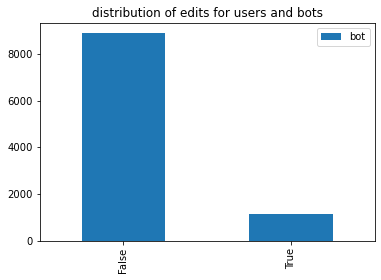

In [ ]:
pandasDF['bot'].value_counts().plot(kind='bar', legend=True, title = "distribution of edits for users and bots")

The data is skewed hardly to the users: there are way more users than bots and the model we have chosed distringuishes well among them, so the model is good

## Further ideas

Because user naming was directly having "Bot" in bots profile we were not be able to use it because of target leakage.
However we could implement time based bloom filters for bots if could use hashed username (or uuid) for instance.
The idea is based on concept that bot often can do a lot of edits on different pages in small timeframe.

If we could use user name (for identification) for training we could use 5 second bloom filters which would store all usernames which done editing in given time frame. If user appears in such filter twice it is probable that such edit is done by bot - it is hard to make chages to page for human in 5 seconds.

Also bots do not use IP adress as their user name. Unfortenatally we cannot use this property as a feature, so it is also left unused.